# 1. Sampling

**Load the given water pipes data and historical failures data into a Pandas DataFrame. Explore the basic statistics and information about the datasets.**

In [ ]:
# Download necessary packages
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from shapely.geometry import Polygon, Point
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import ks_2samp

In [ ]:
# Download dataset.zip from IPFS
!wget -O dataset.zip https://gateway.pinata.cloud/ipfs/QmdV5Q9DpzE81AbhguzwRFPD5WtkqYwSEM72QoBPP7s9kJ

--2024-04-12 13:57:31--  https://gateway.pinata.cloud/ipfs/QmdV5Q9DpzE81AbhguzwRFPD5WtkqYwSEM72QoBPP7s9kJ
Resolving gateway.pinata.cloud (gateway.pinata.cloud)... 172.64.154.225, 104.18.33.31, 2606:4700:4400::ac40:9ae1, ...
Connecting to gateway.pinata.cloud (gateway.pinata.cloud)|172.64.154.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231543 (226K) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 226.12K  --.-KB/s    in 0.02s   

2024-04-12 13:57:32 (12.4 MB/s) - ‘dataset.zip’ saved [231543/231543]



In [ ]:
# Unzip file
import zipfile
with zipfile.ZipFile("/content/dataset.zip", "r") as zip_ref:
    zip_ref.extractall()


# Read .gpkg files into geopandas
pipes = gpd.read_file("/content/pipes.gpkg")
failures = gpd.read_file("/content/failues.gpkg")

In [ ]:
pipes.head(10)

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry
0,10,16,PVC,0,0,"LINESTRING (1622155.699 451307.986, 1622155.73..."
1,1000,8,PVC,0,0,"LINESTRING (1618279.560 450564.909, 1618165.29..."
2,1001,8,PVC,0,0,"LINESTRING (1618164.753 450909.339, 1618167.09..."
3,1002,8,PVC,0,0,"LINESTRING (1618167.097 451315.457, 1618154.24..."
4,1004,8,PVC,0,0,"LINESTRING (1616841.499 449737.437, 1617602.44..."
5,1006,8,PVC,0,0,"LINESTRING (1617602.441 449730.421, 1617874.33..."
6,1009,8,PVC,0,0,"LINESTRING (1617602.441 449730.421, 1617601.74..."
7,1010,8,DI,0,0,"LINESTRING (1612639.571 465066.686, 1612640.19..."
8,1011,8,DI,0,0,"LINESTRING (1612639.571 465066.686, 1612252.91..."
9,1012,8,DI,0,0,"LINESTRING (1612252.913 465066.520, 1612237.99..."


We then proceed with some overall basic statistics

In [ ]:
pipes.describe()

,pipe_diam,abandoned,abandon_yr
count,3368.000000,3368.000000,3368.000000
mean,8.352435,0.002375,4.780285
std,2.474261,0.048686,97.981380
min,3.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000
75%,10.000000,0.000000,0.000000
max,16.000000,1.000000,2018.000000


We can see that the pipes geopandas dataframe consists of 6 features with 3368 observations. One geometrical feature ('geometry'), three numerical ('pipe_diam','abandoned','abandon_year') and two objects ('pipe_id','material').
On closer inspection we can see that the pipe_id is considered an object, meaning it could contain a mix of numerical and non-numerical values. This could hint towards
the existence of string types as well. We can also determine that the pipe_id can also be considered a unique key. The 'material' feature
is in fact a categorical variable determining the pipe material and consists of strings. It is also worth noting that although the pipe_diam appears as
as an integer, it is in fact a categorical variable. Finally the 'abandoned' feature is identified as numerical but can
also be considered a dummy variable taking values between 0 and 1

In [ ]:
pipes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3368 entries, 0 to 3367
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pipe_id     3368 non-null   object  
 1   pipe_diam   3368 non-null   int64   
 2   material    3368 non-null   object  
 3   abandoned   3368 non-null   int64   
 4   abandon_yr  3368 non-null   int64   
 5   geometry    3368 non-null   geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 158.0+ KB


We see that the pipe_id indeed refers to both, active and abandoned pipes, including a number of pipes with the same pipe_id with the abandoned version of the same individual pipe using the 'abd' prefix

In [ ]:
print("Total unique pipe ids: ",len(pipes["pipe_id"].value_counts()))
print(" ")
print(" ")
print("Total abandoned pipes: ",pipes["pipe_id"].str.count("abd").sum())
print(" ")
print(pipes[pipes["pipe_id"].str.contains("abd")])


Total unique pipe ids:  3368
 
 
Total abandoned pipes:  8
 
      pipe_id  pipe_diam material  abandoned  abandon_yr  \
3360   abd169          4      PVC          1        2012   
3361  abd4060          6       AC          1        2015   
3362  abd4061          6       AC          1        2015   
3363  abd4062         12      PVC          1        2012   
3364  abd4102          8       AC          1        2018   
3365  abd5048         12      PVC          1        2007   
3366   abd505          8       DI          1        2013   
3367   abd596          6      PVC          1        2008   

                                               geometry  
3360  LINESTRING (1619790.971 464815.378, 1619806.59...  
3361  LINESTRING (1621909.374 460545.628, 1622232.96...  
3362  LINESTRING (1618285.567 460587.133, 1617519.68...  
3363  LINESTRING (1617693.624 459323.382, 1614292.07...  
3364  LINESTRING (1622602.852 458019.774, 1622603.03...  
3365  LINESTRING (1617690.655 459313.911, 1617831.

We can start by taking a look at relevant statistics per each variable. As far as materials are concerned, we can see that PVC and AC are the most common

In [ ]:
print("Unique material values: ",pipes["material"].unique())
print(" ")
print("Value counts ",pipes["material"].value_counts())

Unique material values:  ['PVC' 'DI' 'AC' 'OTHER' 'STEEL' 'HDPE']
 
Value counts  material
PVC      2003
AC       1179
DI         82
STEEL      76
OTHER      24
HDPE        4
Name: count, dtype: int64


We then create a function to plot for a category and its frequency, taking the parameters 'data' and 'category'

In [ ]:
def plot_categorical(data, category):

    """
    Parameters:
    data (dataframe): Merged dataframe.
    category (string): The dimension according to which we will produce the plot, eg 'material'.

    Returns:
    plot
    """

    assert isinstance(data, pd.DataFrame), "Data must be in dataframe format"
    assert isinstance(category, str), "Category must be in string format"

    data.groupby(category).size().plot(kind="barh", color=sns.palettes.mpl_palette("Dark2"))

    # Add title for x-axis
    plt.xlabel("Count")
    plt.gca().spines[["top", "right",]].set_visible(False)

We can can visualize the 'distribution' of the materials first

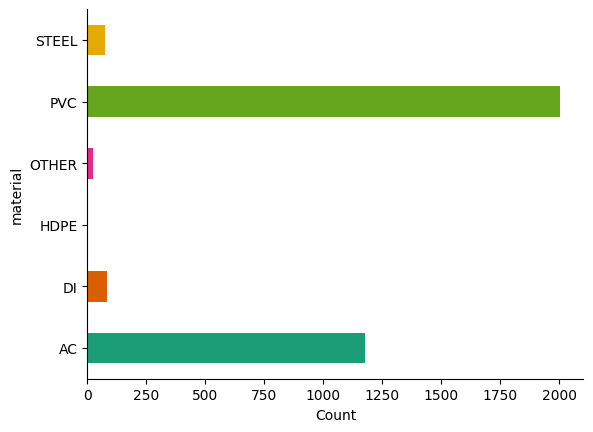

In [ ]:
plot_categorical(pipes,"material")

We can now take a look at the abandoned values

In [ ]:
print("Unique abandoned values: ",pipes['abandoned'].unique(), ", Total Abandoned pipes: ",len(pipes[pipes["abandoned"]==1]))

Unique abandoned values:  [0 1] , Total Abandoned pipes:  8


We can see that the dataset is quite unbalanced on term of the number of pipes abandoned

In [ ]:
print(pipes["abandoned"].value_counts())

abandoned
0    3360
1       8
Name: count, dtype: int64


We can also see that the some of the pipes with the same ids have been abandoned


In [ ]:
print("Total abandoned pipes: ",pipes["pipe_id"].str.count("abd").sum())
print(" ")
display(pipes[pipes["pipe_id"].str.contains("abd")])
print(" ")
display(pipes[pipes["pipe_id"]=="596"])
print(" ")
display(pipes[pipes["pipe_id"]=="abd596"])
print(" ")


Total abandoned pipes:  8
 


,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry
3360,abd169,4,PVC,1,2012,"LINESTRING (1619790.971 464815.378, 1619806.59..."
3361,abd4060,6,AC,1,2015,"LINESTRING (1621909.374 460545.628, 1622232.96..."
3362,abd4061,6,AC,1,2015,"LINESTRING (1618285.567 460587.133, 1617519.68..."
3363,abd4062,12,PVC,1,2012,"LINESTRING (1617693.624 459323.382, 1614292.07..."
3364,abd4102,8,AC,1,2018,"LINESTRING (1622602.852 458019.774, 1622603.03..."
3365,abd5048,12,PVC,1,2007,"LINESTRING (1617690.655 459313.911, 1617831.13..."
3366,abd505,8,DI,1,2013,"LINESTRING (1622247.323 459251.676, 1622735.54..."
3367,abd596,6,PVC,1,2008,"LINESTRING (1626133.001 454982.382, 1626794.77..."


,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry
2795,596,6,PVC,0,0,"LINESTRING (1626133.001 454982.382, 1626794.77..."


,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry
3367,abd596,6,PVC,1,2008,"LINESTRING (1626133.001 454982.382, 1626794.77..."


Next, we can take a look at some basic statistics for the pipe_diam which is a categorical variable. We can easily determine that the most common pipe type is of a diameter of 8 inches, closely followed by diameters of 12 and 6 inches. A 4 inch diameter is fairly common whereas the 16,10 and 3 inch diameter pipes are not as common

In [ ]:
pipes["pipe_diam"].value_counts().sort_values(ascending=False)

pipe_diam
8     1561
12     813
6      760
4      183
16      27
10      13
3       11
Name: count, dtype: int64

We can also create a function that returns histogram plots, taking two parameters, a dataframe and a feature

In [ ]:
def plot_hist(data,feature):

    """
    Parameters:
    data (dataframe): Dataframe.
    feature (string): The dimension according to which we will produce the histogram plot, eg 'material'.

    Returns:
    plot of histogram
    """

    assert isinstance(data, pd.DataFrame), "Data must be in dataframe format"
    assert isinstance(feature, str), "Feature must be in string format"

    data[feature].plot(kind="hist", bins=20, title=feature)

    # Format x-label values as integers
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

    plt.title("Histogram plot of "+feature)

    # Add title for x-axis
    plt.xlabel(feature)
    plt.gca().spines[["top", "right",]].set_visible(False)

We apply this on the pipe diameter

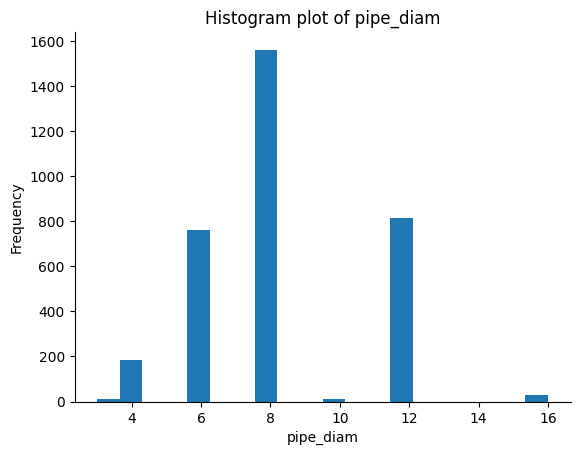

In [ ]:
plot_hist(pipes,"pipe_diam")

It would be interesting to consider the length dimension as well


In [ ]:
pipes.set_geometry("geometry")
pipes["pipe_length"]=pipes["geometry"].length

pipes.head(10)

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry,pipe_length
0,10,16,PVC,0,0,"LINESTRING (1622155.699 451307.986, 1622155.73...",786.189379
1,1000,8,PVC,0,0,"LINESTRING (1618279.560 450564.909, 1618165.29...",114.262620
2,1001,8,PVC,0,0,"LINESTRING (1618164.753 450909.339, 1618167.09...",406.125046
3,1002,8,PVC,0,0,"LINESTRING (1618167.097 451315.457, 1618154.24...",12.849080
4,1004,8,PVC,0,0,"LINESTRING (1616841.499 449737.437, 1617602.44...",760.975048
5,1006,8,PVC,0,0,"LINESTRING (1617602.441 449730.421, 1617874.33...",271.888684
6,1009,8,PVC,0,0,"LINESTRING (1617602.441 449730.421, 1617601.74...",455.837549
7,1010,8,DI,0,0,"LINESTRING (1612639.571 465066.686, 1612640.19...",273.252141
8,1011,8,DI,0,0,"LINESTRING (1612639.571 465066.686, 1612252.91...",386.658055
9,1012,8,DI,0,0,"LINESTRING (1612252.913 465066.520, 1612237.99...",386.754717


We can see that the PVC pipes are the longest in the network, closely followed by the AC

In [ ]:
total_length_per_material = pipes.groupby("material")["pipe_length"].sum()
total_length_per_material.sort_values(ascending=False)

material
PVC      540274.567312
AC       349102.320602
STEEL     24305.426749
DI        18655.278547
OTHER      7537.514535
HDPE        558.318908
Name: pipe_length, dtype: float64

Lets also consider total length by diameter. We can see that the longest pipes are the 8, 12 and 6 inch respectively

In [ ]:
total_length_per_diameter = pipes.groupby("pipe_diam")["pipe_length"].sum()
total_length_per_diameter.sort_values(ascending=False)

pipe_diam
8     384151.025987
12    278684.378399
6     208734.000562
4      52737.440677
16      9996.690991
3       3466.342334
10      2663.547702
Name: pipe_length, dtype: float64

We can also encode some categorical variables to facilitate future analyses. We can do that on the material and material/diameter


In [ ]:
pipes["encoded_material"] = LabelEncoder().fit_transform(pipes["material"])
pipes["material_diam"] = pipes["material"]+'_'+pipes["pipe_diam"].astype(str)
pipes["material_diam_encoded"]= LabelEncoder().fit_transform(pipes["material_diam"])

Also what about considering material, diam and length together? We can see that the PVC 8 and 12 inch are the most common, closely followed by AC 6,8 and 12 inch


In [ ]:
total_length_per_material_diameter = pipes.groupby(["material","pipe_diam"])["pipe_length"].sum()
total_length_per_material_diameter.sort_values(ascending=False)

material  pipe_diam
PVC       8            271824.007790
          12           195283.861035
AC        6            143289.786136
          8            105601.782848
          12            67286.534411
PVC       6             47902.840724
AC        4             30688.639856
STEEL     6             15579.013788
PVC       4             13638.051155
DI        12            12324.440275
PVC       16             9327.287406
STEEL     4              8353.485364
DI        8              5020.915948
OTHER     12             3419.041376
AC        10             2120.140615
PVC       3              2081.517926
OTHER     8              1701.893104
          6              1358.567225
          3               724.921501
DI        16              669.403585
          6               603.792690
HDPE      3               544.466171
STEEL     12              370.501301
OTHER     10              326.405811
PVC       10              217.001276
AC        3               115.436736
DI        4       

We can visualize the pipe material/diameter type frequency

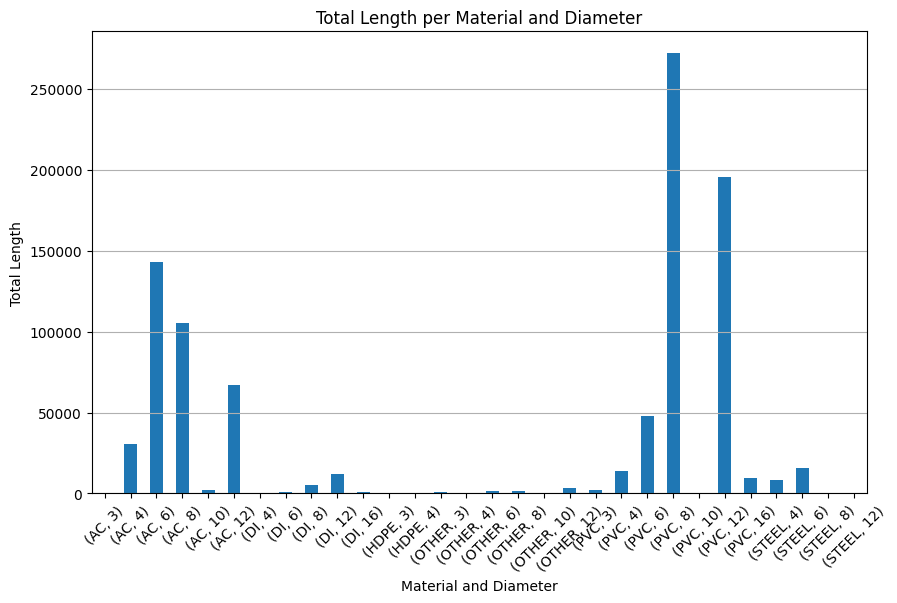

In [ ]:
total_length_per_material_diameter.plot(kind="bar", figsize=(10, 6))
plt.title("Total Length per Material and Diameter")
plt.xlabel("Material and Diameter")
plt.ylabel("Total Length")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

We can now do some visual of the dataset as a whole. Since we have a geopandas, we can start by visualizing the spatial dimension of the pipes.


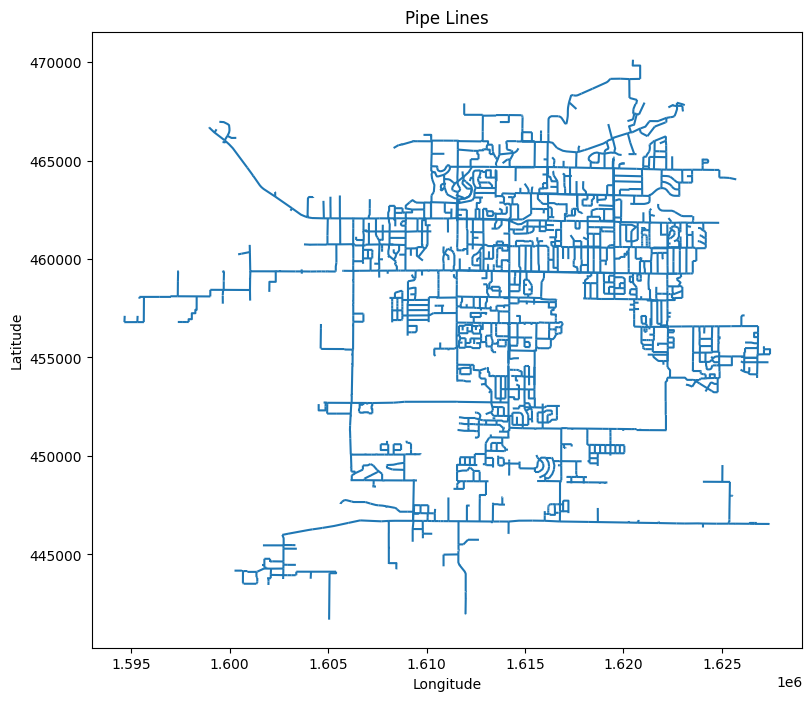

In [ ]:
pipes.plot(figsize=(10, 8))
plt.title("Pipe Lines")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In addition to the spatial dimension we can also add a qualitative dimension.
First we create a plot function per pipe dimension

In [ ]:
def pipeplot_bydimension(data,dimension,title):

  """
  Parameters:
  data (dataframe): Merged dataframe.
  dimension (string): The dimension according to which we will produce the plot, eg 'material'.
  title (string): The title of the plot.

  Returns:
  plot
  """

  assert isinstance(data, pd.DataFrame), "Data must be in dataframe format"
  assert isinstance(dimension, str), "Dimension must be in string format"
  assert isinstance(title, str), "Title must be in string format"

  data.plot(column=dimension, linewidth=2, figsize=(10, 8), legend=True)
  plt.title(title)
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()

It would be interesting to consider the material of the pipes

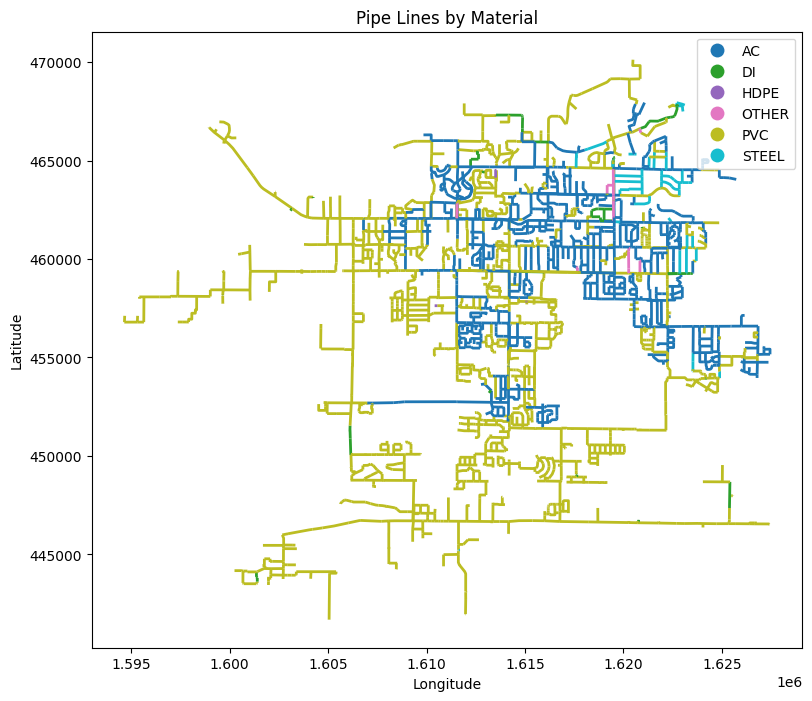

In [ ]:
pipeplot_bydimension(pipes,"material","Pipe Lines by Material")

Or diameter of the pipe


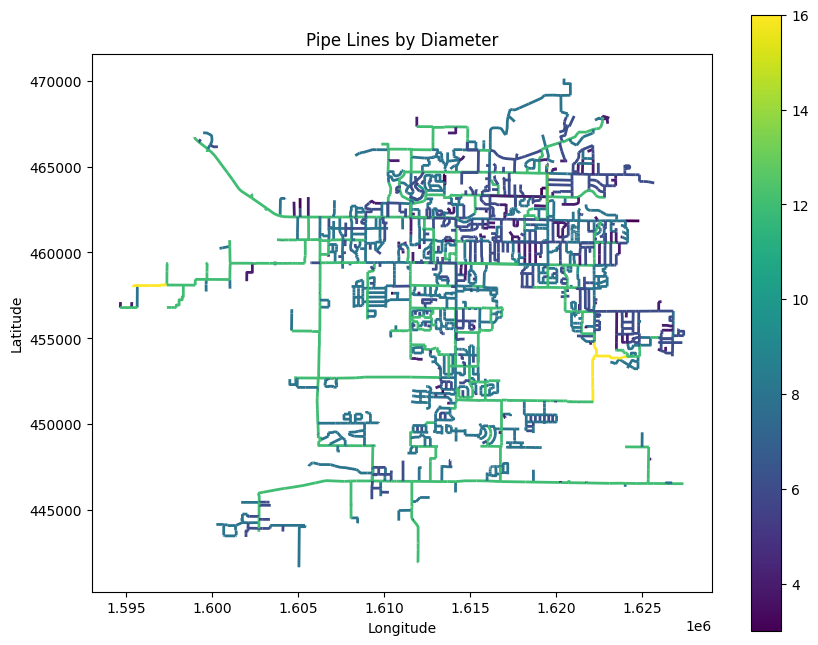

In [ ]:
pipeplot_bydimension(pipes,"pipe_diam","Pipe Lines by Diameter")

Finally a spatial plot by material and diameter

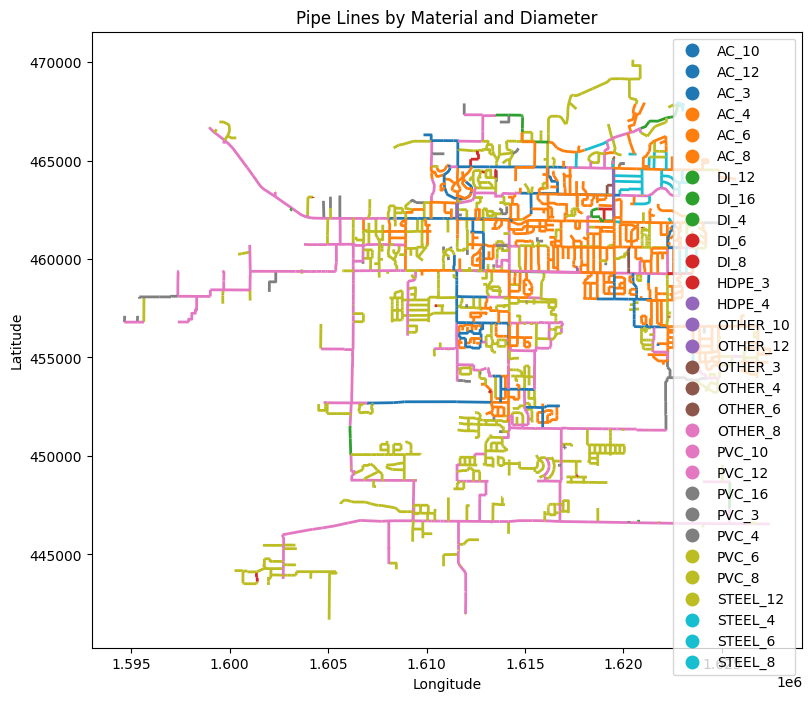

In [ ]:
pipeplot_bydimension(pipes, "material_diam","Pipe Lines by Material and Diameter")

Now, lets take a look at the failures dataset

In [ ]:
failures.head(20)

,event_id,pipe_id,event_year,geometry
0,0,2207,2015,POINT (1602587.186 459372.774)
1,1,5710,2016,POINT (1624859.821 454637.402)
2,2,1678,2016,POINT (1609133.814 465975.308)
3,3,4037,2016,POINT (1602735.809 444074.487)
4,4,2072,2016,POINT (1615166.879 451585.757)
5,5,5432,2017,POINT (1624160.023 453949.338)
6,6,761,2017,POINT (1620778.586 463550.032)
7,7,4492,2017,POINT (1606323.354 462072.437)
8,8,4118,2017,POINT (1611772.202 466005.979)
9,9,607,2017,POINT (1624741.924 455053.630)


First some basic statistics

In [ ]:
failures.describe()

,event_year
count,91.000000
mean,2012.263736
std,4.671034
min,2002.000000
25%,2008.000000
50%,2013.000000
75%,2016.000000
max,2020.000000


We have a total of four variables in the dataframe. We can see that event and pipe ids are objects, meaning that as in the pipes dataframe there can be strings included instead of just numbers. The event year is a categorical variable, whereas the geometry is its namesake's type

In [ ]:
failures.dtypes

event_id        object
pipe_id         object
event_year       int64
geometry      geometry
dtype: object

Given the nature of the data, we can analyse them in conjunction with others as an individual assessment makes less sense. After initial inspection of the pipe_id we can see that it contains active and abandoned pipes (as shown by the 'abd' prefix in a number of cases).

We can start by seeing that some pipes have burst more than once, with pipe abd4061 having burst the most times


In [ ]:
print(failures["pipe_id"].value_counts())
print(" ")
print("Total abandoned pipes: ",failures["pipe_id"].str.count("abd").sum())
print(" ")
display(failures[failures["pipe_id"].str.contains("abd")])

pipe_id
abd4061    5
4062       5
abd596     4
282        3
2207       2
          ..
261        1
3685       1
5710       1
192        1
2507       1
Name: count, Length: 71, dtype: int64
 
Total abandoned pipes:  15
 


,event_id,pipe_id,event_year,geometry
14,14,abd4061,2015,POINT (1618177.001 460590.482)
15,15,abd4060,2015,POINT (1622211.293 460542.763)
27,27,abd505,2013,POINT (1622542.043 459255.360)
38,38,abd169,2012,POINT (1619796.509 464815.378)
46,46,abd4061,2011,POINT (1618048.499 460592.583)
54,54,abd4061,2008,POINT (1617840.330 460595.326)
55,55,abd596,2008,POINT (1626499.330 454980.282)
62,62,abd596,2007,POINT (1626757.326 454974.708)
63,63,abd596,2007,POINT (1626702.584 454978.667)
65,65,abd5048,2007,POINT (1617786.950 459313.600)


We can take a look at the histogram for the event_year

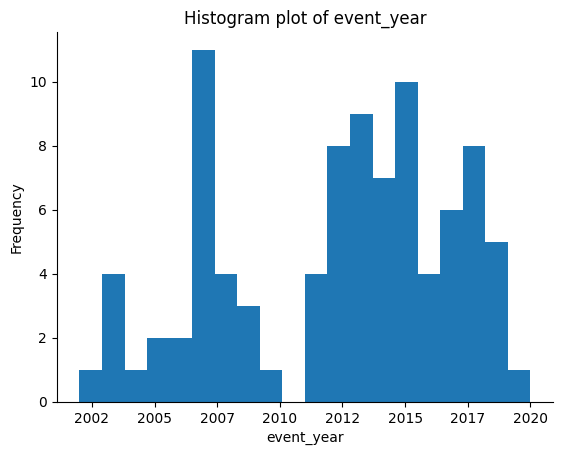

In [ ]:
plot_hist(failures,"event_year")

We can see that most accidents happened 2007, but more than twice as much accidents were placed between 2011 and 2020, compared to between 2002 and 2010

In [ ]:
print(failures["event_year"].value_counts())

print(" ")

print(failures["event_year"].describe())

print(" ")

print("Accidents between 2002 and 2010: ",len(failures[failures["event_year"] <= 2010]))

print(" ")

print("Accidents between 2011 and 2020: ",len(failures[failures["event_year"] > 2010]))

event_year
2007    11
2015    10
2013     9
2012     8
2018     8
2014     7
2017     6
2019     5
2003     4
2008     4
2016     4
2011     4
2009     3
2005     2
2006     2
2004     1
2020     1
2002     1
2010     1
Name: count, dtype: int64
 
count      91.000000
mean     2012.263736
std         4.671034
min      2002.000000
25%      2008.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: event_year, dtype: float64
 
Accidents between 2002 and 2010:  29
 
Accidents between 2011 and 2020:  62


Finally lets complete our basic statistics analysis with some visual analysis of the spatial distribution of failure points

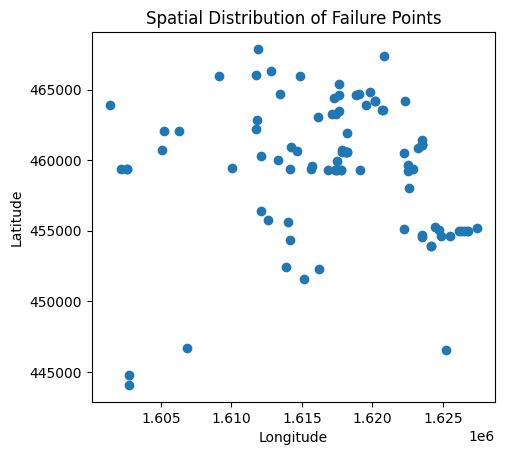

In [ ]:
failures.plot()
plt.title("Spatial Distribution of Failure Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

And also spatial distribution of failure points by year

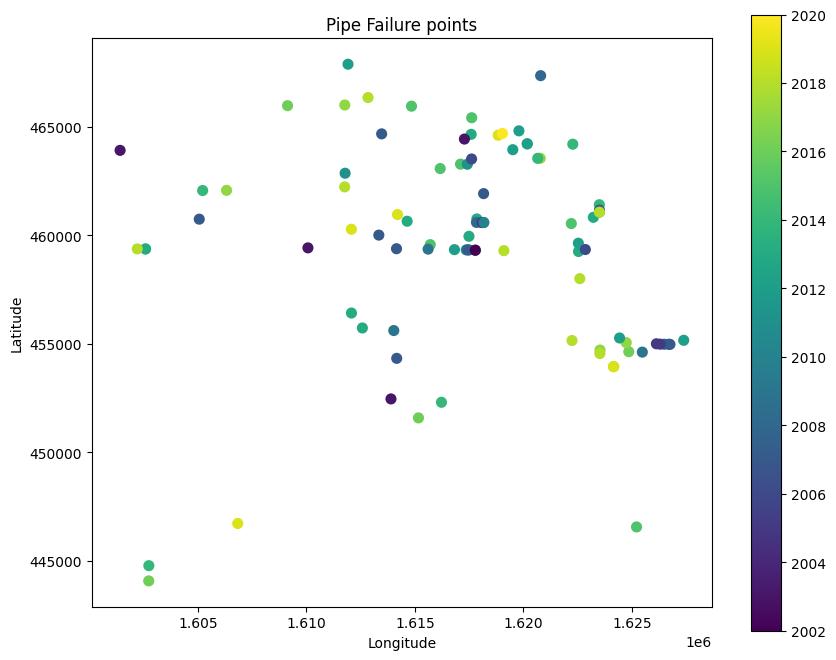

In [ ]:
pipeplot_bydimension(failures, "event_year","Pipe Failure points")

Finally it would be interesting to superimpose the failures over the system and get some spatial statistics per zones

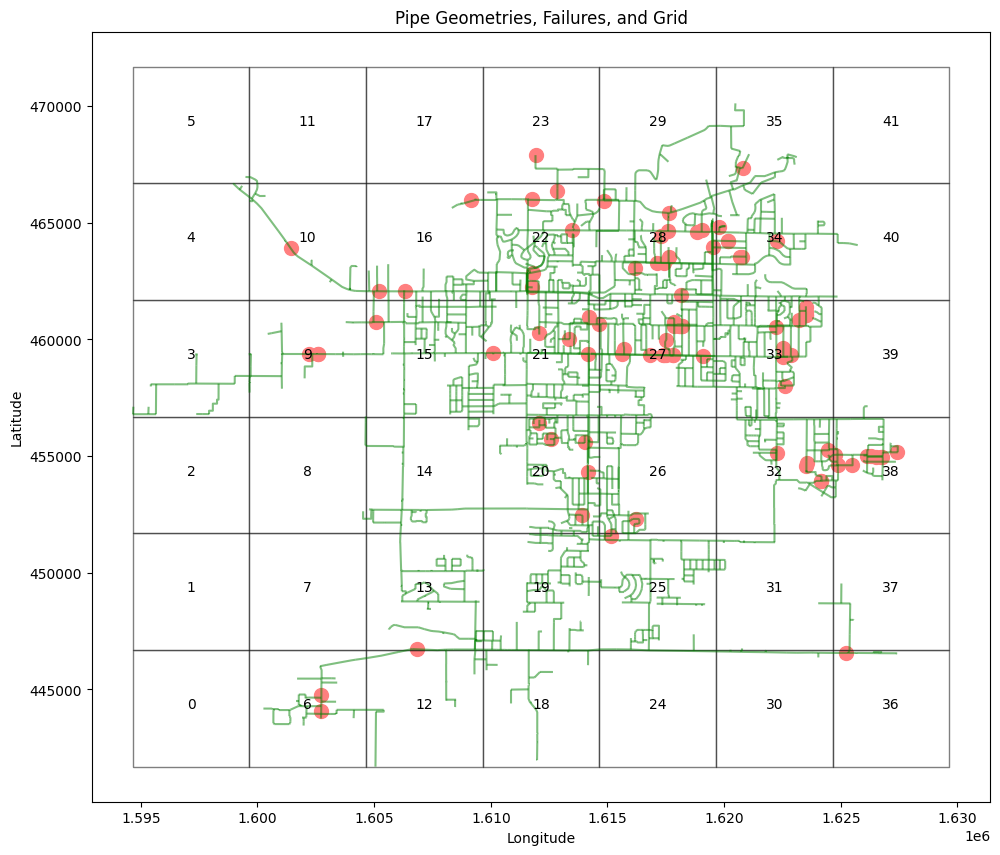

In [ ]:
# Assuming pipes is your GeoDataFrame
# 1. Determine the extent of the study area (bounding box)
min_x, min_y, max_x, max_y = pipes.total_bounds

# 2. Define the dimensions of the grid cells
cell_size = 5000  # Adjust this value according to your study area and desired cell size
width = height = cell_size

# 3. Create a GeoDataFrame representing the grid
grid_polygons = []
for x in range(int(min_x), int(max_x), width):
    for y in range(int(min_y), int(max_y), height):
        # Define the vertices of the rectangle
        vertices = [(x, y), (x + width, y), (x + width, y + height), (x, y + height)]
        # Create the polygon
        grid_polygons.append(Polygon(vertices))

# Create a GeoDataFrame from the grid polygons
grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons)
grid_gdf["zone"]=grid_gdf.index

# Plot the pipe geometries, failure points, and grid on the same subplot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the pipe geometries
pipes.plot(ax=ax, color="green", alpha=0.5)

# Plot the failure points
failures.plot(ax=ax, color="red", marker='o', markersize=100)

# Plot the grid
grid_gdf.plot(ax=ax, color="white", alpha=0.5, edgecolor="black")

# Annotate each zone with its name
for index, row in grid_gdf.iterrows():
    ax.annotate(text=row["zone"], xy=(row.geometry.centroid.x, row.geometry.centroid.y), color="black", fontsize=10, ha="center")

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Pipe Geometries, Failures, and Grid")

# Show the plot
plt.show()

We would like to consider the density of failures per area. We then proceed by creating a function called "in_polygon_check" that will identify the zone (which grid area) per failure point in the failures dataframe

In [ ]:
polycoorslist = grid_gdf.geometry.tolist()
id_zones = grid_gdf.zone.tolist()

def in_polygon_check(coordinate):
    """
    The function checks if a specific coordinate is within a grid polygon
    parameter:
    coordinate(list): the coordinate of the failure point to be assigned an area
    """

    # Assert that 'my_variable' is a list
    assert isinstance(coordinate, list), "Coordinate must be a list"

    # Turn point into readable format for geopandas polygons
    coordinate = Point(coordinate)
    i=0
    position=0

    # Iterates all polygons in the list to check if the point pertains to one of them
    for poly in polycoorslist:
        polygon = Polygon(poly)

    # Check if failure's position is in the polygon
        check1 = polygon.contains(coordinate)

    # Check if failure's position lies on border of polygon
        check2 = polygon.touches(coordinate)

    # If the position is in/or a polygon, then it is assigned to the equivalent polygon and it's area
        if check1 == True or check2 == True:
            position = id_zones[i]
            return position
        i+=1
    # If no polygons include the coordinate, it's area is determined as "Null"
    position=None

    return position

We create an areas list to gather the areas of each failure point

In [ ]:
areas = []
for i in range(0, len(failures)):
  areas.append(in_polygon_check([failures["geometry"].geometry.iloc[i].x, failures["geometry"].geometry.iloc[i].y]))

failures["areas"] = areas

failures.head()

,event_id,pipe_id,event_year,geometry,areas
0,0,2207,2015,POINT (1602587.186 459372.774),9
1,1,5710,2016,POINT (1624859.821 454637.402),38
2,2,1678,2016,POINT (1609133.814 465975.308),16
3,3,4037,2016,POINT (1602735.809 444074.487),6
4,4,2072,2016,POINT (1615166.879 451585.757),25


Finally we can see that the areas with the hightest density of failures are 27, 28, 33 and 28

In [ ]:
failures["areas"].value_counts()

areas
27    16
28    12
33    10
38     9
21     6
32     6
34     6
20     5
22     5
9      3
16     3
6      2
36     1
25     1
26     1
23     1
35     1
15     1
10     1
13     1
Name: count, dtype: int64

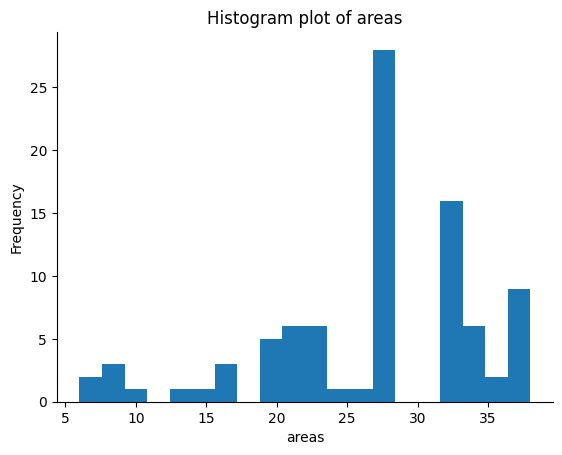

In [ ]:
plot_hist(failures,"areas")

**Merge the water pipes data with the failures data based on a common identifier. Validate the merged dataset to ensure that all relevant information is preserved.**

We can consider two merged datasets:

i) The first one that lies in the intersection of the pipes and failures dataframes ie aggregates the failures dataframes with the features of the pipes dataframes corresponding to the respective unique pipe_ids

ii) A second one that creates a merged dataset with the historical failures of active and abandoned pipes, with an extra class

Lets start with the first case. We initially observe that #We can see that we have different lengths in the two datasets


In [ ]:
print("Length of Failures: ", len(failures))
print("Length of Pipes: ", len(pipes))

Length of Failures:  91
Length of Pipes:  3368


We can determine if all of the pipe ids in failures are included in the pipes geopandas:

In [ ]:
all_values_included = failures["pipe_id"].isin(pipes["pipe_id"]).all()
all_values_included

True

We can see that all the pipe ids are unique in the pipes geopandas dataframe

In [ ]:
len(pipes["pipe_id"].unique())

3368

On the other hand that is not the case for the failures one. This means that some pipes might have burst more than once

In [ ]:
len(failures["pipe_id"].unique())

71

Indeed, 11 pipes have burst more than once

In [ ]:
failure_counts = failures["pipe_id"].value_counts()
len(failure_counts.loc[failure_counts > 1])

11

We will now creat the first case of the merged data. We will use an inner merge, which will create a dataset accounting for the pipes that have burst including recurring cases.

In [ ]:
pipes.set_geometry("geometry")
failures.set_geometry("geometry")
data_merged = pipes.merge(failures, on="pipe_id", suffixes=("_1", "_2"), how="inner")
data_merged.head(100)

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry_1,pipe_length,encoded_material,material_diam,material_diam_encoded,event_id,event_year,geometry_2,areas
0,1094,8,AC,0,0,"LINESTRING (1616369.495 452200.897, 1616359.43...",374.195777,0,AC_8,5,25,2014,POINT (1616226.717 452305.211),26
1,1265,8,AC,0,0,"LINESTRING (1614165.338 454066.340, 1614162.39...",472.340246,0,AC_8,5,59,2007,POINT (1614164.803 454330.667),20
2,1415,8,AC,0,0,"LINESTRING (1613164.147 460010.149, 1613385.26...",221.114108,0,AC_8,5,60,2007,POINT (1613340.133 460010.266),21
3,1650,8,PVC,0,0,"LINESTRING (1624885.211 454604.691, 1624889.34...",1068.789021,4,PVC_8,25,50,2009,POINT (1625484.000 454617.437),38
4,1678,8,PVC,0,0,"LINESTRING (1609342.253 465978.146, 1608742.33...",624.312021,4,PVC_8,25,2,2016,POINT (1609133.814 465975.308),16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,abd505,8,DI,1,2013,"LINESTRING (1622247.323 459251.676, 1622735.54...",488.261896,1,DI_8,10,27,2013,POINT (1622542.043 459255.360),33
87,abd596,6,PVC,1,2008,"LINESTRING (1626133.001 454982.382, 1626794.77...",661.773074,4,PVC_6,24,55,2008,POINT (1626499.330 454980.282),38
88,abd596,6,PVC,1,2008,"LINESTRING (1626133.001 454982.382, 1626794.77...",661.773074,4,PVC_6,24,62,2007,POINT (1626757.326 454974.708),38
89,abd596,6,PVC,1,2008,"LINESTRING (1626133.001 454982.382, 1626794.77...",661.773074,4,PVC_6,24,63,2007,POINT (1626702.584 454978.667),38


In [ ]:
print("Total observations:", data_merged.shape[0])
print(" ")
print("Unique pipe_ids:", len(data_merged["pipe_id"].unique()))

Total observations: 91
 
Unique pipe_ids: 71


We have no missing values

In [ ]:
data_merged.isnull().sum()

pipe_id                  0
pipe_diam                0
material                 0
abandoned                0
abandon_yr               0
geometry_1               0
pipe_length              0
encoded_material         0
material_diam            0
material_diam_encoded    0
event_id                 0
event_year               0
geometry_2               0
areas                    0
dtype: int64

Finally we can crosscheck the corresponding values for each pipe id with their pipes and failures geopandas equivalents by creating a function called "checked_mergedf_consistency". We can see that all values from the data_merged features correspond to their respective pipes and failures values per pipe_id


In [ ]:
def check_pipes_in_merged(pipes, data_merged):

    """
    Helper function to check if pipes are contained within the merged dataframe

    Parameters:
    pipes (dataframe): the pipes Dataframe.
    data_merged (dataframe): The merged Dataframe.

    Returns:
    count of common rows between failures and data_merged for common columns
    """

    count=0
    results_values_pipes = []
    for index, row in data_merged.iterrows():

        pipe_id = row["pipe_id"] # Get the pipe ID from the merged DataFrame

        # Check pipes counterpart

        for column in pipes.columns:
            expected = pipes.loc[pipes["pipe_id"] == pipe_id, column]
            if column == "geometry":
                results_values_pipes.append(expected == row["geometry_1"])
            else:
                results_values_pipes.append(expected == row[column])


    # Flatten the list of boolean values
    flattened_results = [item for sublist in results_values_pipes for item in sublist]

    # Count the number of True values
    count = int(flattened_results.count(True)/len(pipes.columns))

    return count

In [ ]:
def check_failures_in_merged(failures, data_merged):

    """
    Helper function to check if failures are contained within the merged dataframe

    Parameters:
    failures (dataframe): the failures Dataframe.
    data_merged (dataframe): The merged Dataframe.

    Returns:
    count of common rows between failures and data_merged for common columns
    """

    count=0
    for index, row in data_merged.iterrows():

        pipe_id = row['pipe_id'] # Get the pipe ID from the merged DataFrame

        expected_event_id = failures.loc[failures["pipe_id"] == pipe_id, "event_id"].tolist()
        expected_event_year = failures.loc[failures["pipe_id"] == pipe_id, "event_year"].tolist()
        expected_geometry_2 = failures.loc[failures["pipe_id"] == pipe_id, "geometry"].tolist()

        for i in range(0,len(expected_event_id)):
          result_geometry_2 = expected_geometry_2[i] == row["geometry_2"]
          result_event_year = expected_event_year[i] == row["event_year"]
          result_event_id = expected_event_id[i] == row["event_id"]
          if result_geometry_2 == result_event_year == result_event_id==True:
            count+=1


    return count

In [ ]:
def check_mergedf_consistency(failures, pipes, data_merged):

    """
    Function to check if failures and pipes dataframes are contained within the merged dataframe

    Parameters:
    failures (dataframe): the failures Dataframe.
    pipes (dataframe): the pipes Dataframe.
    data_merged (dataframe): The merged Dataframe.

    """

    check1 = check_failures_in_merged(failures, data_merged)
    check2 = check_pipes_in_merged(pipes, data_merged)

    if check1 == check2:
        print("The Merged Dataframe corresponds element wise to its constituent dataframes for", check1, "unique observations" )


In [ ]:
check_mergedf_consistency(failures, pipes, data_merged)

The Merged Dataframe corresponds element wise to its constituent dataframes for 91 unique observations


Now we can proceed to the second case where we create a wider database with both failed and non-failed active and abandoned pipes, grouped by pipe_id. We thus group by the first column and aggregate the other columns creating lists of elements for unique pipe ids with more than one cases of failures

In [ ]:
# We first group by pipe_id and then aggregate the values of extra occurences in lists. In this way
# each unique id has lists of all failure metadata per row
grouped_df = data_merged.groupby(data_merged.iloc[0:, 0]).agg(lambda x: list(x)[0] if len(list(set(x))) == 1 else list(set(x)) )

# We reset the index to ensure consistency
grouped_df.reset_index(drop=True, inplace=True)

# We create an extra column called 'failures', that counts the number of observed failures per unique pipe id
# facilitate future analytics
grouped_df["failures"] = grouped_df["event_year"].map(lambda x: len(x) if isinstance(x, list) else 1)

# We create a new class for the failed assigning the value 1 to all failed individual active and
# abandoned pipes
grouped_df["failed"] = 1

grouped_df.head(100)

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry_1,pipe_length,encoded_material,material_diam,material_diam_encoded,event_id,event_year,geometry_2,areas,failures,failed
0,1094,8,AC,0,0,"LINESTRING (1616369.495 452200.897, 1616359.43...",374.195777,0,AC_8,5,25,2014,POINT (1616226.7169923931 452305.21099339426),26,1,1
1,1265,8,AC,0,0,"LINESTRING (1614165.338 454066.340, 1614162.39...",472.340246,0,AC_8,5,59,2007,POINT (1614164.8034653068 454330.6665881425),20,1,1
2,1415,8,AC,0,0,"LINESTRING (1613164.147 460010.149, 1613385.26...",221.114108,0,AC_8,5,60,2007,POINT (1613340.132870555 460010.26644939184),21,1,1
3,1650,8,PVC,0,0,"LINESTRING (1624885.211 454604.691, 1624889.34...",1068.789021,4,PVC_8,25,50,2009,POINT (1625483.9999869764 454617.43734006584),38,1,1
4,1678,8,PVC,0,0,"LINESTRING (1609342.253 465978.146, 1608742.33...",624.312021,4,PVC_8,25,2,2016,POINT (1609133.813527301 465975.3079969734),16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,abd4061,6,AC,1,2015,"LINESTRING (1618285.567 460587.133, 1617519.68...",766.014265,0,AC_6,4,"[70, 14, 46, ART_14, 54]","[2004, 2008, 2010, 2011, 2015]","[POINT (1618118.5206234753 460590.207218647), ...",27,5,1
67,abd4102,8,AC,1,2018,"LINESTRING (1622602.852 458019.774, 1622603.03...",448.066575,0,AC_8,5,81,2018,POINT (1622602.8810773045 458003.3301745653),33,1,1
68,abd5048,12,PVC,1,2007,"LINESTRING (1617690.655 459313.911, 1617831.13...",140.479453,4,PVC_12,20,"[ART_65, 65]","[2002, 2007]",POINT (1617786.9497643113 459313.5998637229),27,2,1
69,abd505,8,DI,1,2013,"LINESTRING (1622247.323 459251.676, 1622735.54...",488.261896,1,DI_8,10,27,2013,POINT (1622542.0429443866 459255.3598227203),33,1,1


We identify that we have a total of 71 individual abandoned and active pipes with cases of failure


In [ ]:
len(grouped_df)

71

Finally, we can clean the dataset a bit and have the complete merged dataframe of case 2 called 'final_merged_df'


In [ ]:
# First we rename the geometry column in the pipes dataframe
pipes_pre_merge = pipes
pipes_pre_merge.rename(columns={"geometry": "geometry_1"}, inplace=True)

# Then we merge the pipes and grouped_df dataframe on the common features
final_merged_df =  pd.merge(pipes_pre_merge, grouped_df, on=["pipe_id","pipe_diam"	,"material"	,"abandoned"	,"abandon_yr"	,"geometry_1"	,"pipe_length"	,"encoded_material"	,"material_diam",	"material_diam_encoded"], how="outer")

# We deal with all other missing values by assigning them to zeroes
final_merged_df.fillna(0,inplace=True)

# We fix the values of the geometry_2 column(location of pipe failure) to None for non-failed pipes
final_merged_df.loc[final_merged_df["failed"] != 1, "geometry_2"] = None


# The end result looks like this:
final_merged_df.head(10)

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry_1,pipe_length,encoded_material,material_diam,material_diam_encoded,event_id,event_year,geometry_2,areas,failures,failed
0,10,16,PVC,0,0,"LINESTRING (1622155.699 451307.986, 1622155.73...",786.189379,4,PVC_16,21,0,0,None,0.0,0.0,0.0
1,1000,8,PVC,0,0,"LINESTRING (1618279.560 450564.909, 1618165.29...",114.262620,4,PVC_8,25,0,0,None,0.0,0.0,0.0
2,1001,8,PVC,0,0,"LINESTRING (1618164.753 450909.339, 1618167.09...",406.125046,4,PVC_8,25,0,0,None,0.0,0.0,0.0
3,1002,8,PVC,0,0,"LINESTRING (1618167.097 451315.457, 1618154.24...",12.849080,4,PVC_8,25,0,0,None,0.0,0.0,0.0
4,1004,8,PVC,0,0,"LINESTRING (1616841.499 449737.437, 1617602.44...",760.975048,4,PVC_8,25,0,0,None,0.0,0.0,0.0
5,1006,8,PVC,0,0,"LINESTRING (1617602.441 449730.421, 1617874.33...",271.888684,4,PVC_8,25,0,0,None,0.0,0.0,0.0
6,1009,8,PVC,0,0,"LINESTRING (1617602.441 449730.421, 1617601.74...",455.837549,4,PVC_8,25,0,0,None,0.0,0.0,0.0
7,1010,8,DI,0,0,"LINESTRING (1612639.571 465066.686, 1612640.19...",273.252141,1,DI_8,10,0,0,None,0.0,0.0,0.0
8,1011,8,DI,0,0,"LINESTRING (1612639.571 465066.686, 1612252.91...",386.658055,1,DI_8,10,0,0,None,0.0,0.0,0.0
9,1012,8,DI,0,0,"LINESTRING (1612252.913 465066.520, 1612237.99...",386.754717,1,DI_8,10,0,0,None,0.0,0.0,0.0


We can then visualize all the failed cases

In [ ]:
final_merged_df[final_merged_df["failed"]==1]

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry_1,pipe_length,encoded_material,material_diam,material_diam_encoded,event_id,event_year,geometry_2,areas,failures,failed
53,1094,8,AC,0,0,"LINESTRING (1616369.495 452200.897, 1616359.43...",374.195777,0,AC_8,5,25,2014,POINT (1616226.7169923931 452305.21099339426),26.0,1.0,1.0
179,1265,8,AC,0,0,"LINESTRING (1614165.338 454066.340, 1614162.39...",472.340246,0,AC_8,5,59,2007,POINT (1614164.8034653068 454330.6665881425),20.0,1.0,1.0
295,1415,8,AC,0,0,"LINESTRING (1613164.147 460010.149, 1613385.26...",221.114108,0,AC_8,5,60,2007,POINT (1613340.132870555 460010.26644939184),21.0,1.0,1.0
445,1650,8,PVC,0,0,"LINESTRING (1624885.211 454604.691, 1624889.34...",1068.789021,4,PVC_8,25,50,2009,POINT (1625483.9999869764 454617.43734006584),38.0,1.0,1.0
463,1678,8,PVC,0,0,"LINESTRING (1609342.253 465978.146, 1608742.33...",624.312021,4,PVC_8,25,2,2016,POINT (1609133.813527301 465975.3079969734),16.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,abd4061,6,AC,1,2015,"LINESTRING (1618285.567 460587.133, 1617519.68...",766.014265,0,AC_6,4,"[70, 14, 46, ART_14, 54]","[2004, 2008, 2010, 2011, 2015]","[POINT (1618118.5206234753 460590.207218647), ...",27.0,5.0,1.0
3364,abd4102,8,AC,1,2018,"LINESTRING (1622602.852 458019.774, 1622603.03...",448.066575,0,AC_8,5,81,2018,POINT (1622602.8810773045 458003.3301745653),33.0,1.0,1.0
3365,abd5048,12,PVC,1,2007,"LINESTRING (1617690.655 459313.911, 1617831.13...",140.479453,4,PVC_12,20,"[ART_65, 65]","[2002, 2007]",POINT (1617786.9497643113 459313.5998637229),27.0,2.0,1.0
3366,abd505,8,DI,1,2013,"LINESTRING (1622247.323 459251.676, 1622735.54...",488.261896,1,DI_8,10,27,2013,POINT (1622542.0429443866 459255.3598227203),33.0,1.0,1.0


Finally we can create a function to produce a plot superimposing the failures on the system

In [ ]:
def failures_system_category(data,category):

    """
    Parameters:
    data (dataframe): Merged dataframe.
    category (string): The dimension according to which we will produce the plot, eg 'material'.

    Returns:
    plot
    """

    assert isinstance(category, str), "Category must be string"

    data.set_geometry("geometry_1", inplace=True)
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot pipes on the subplot
    data.plot(ax=ax, column=category, linewidth=2, legend=True)

    for geom in data["geometry_2"]:
      if geom!=None:
        if isinstance(geom, list):
            for point in geom:
                gpd.GeoSeries(point).plot(ax=ax, color="red")
        else:
            gpd.GeoSeries(geom).plot(ax=ax, color="red")

    # Set title and labels
    plt.title("Failure Points on System by {}".format(category))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Show the plot
    plt.show()

We can visualize point failures by material in the system


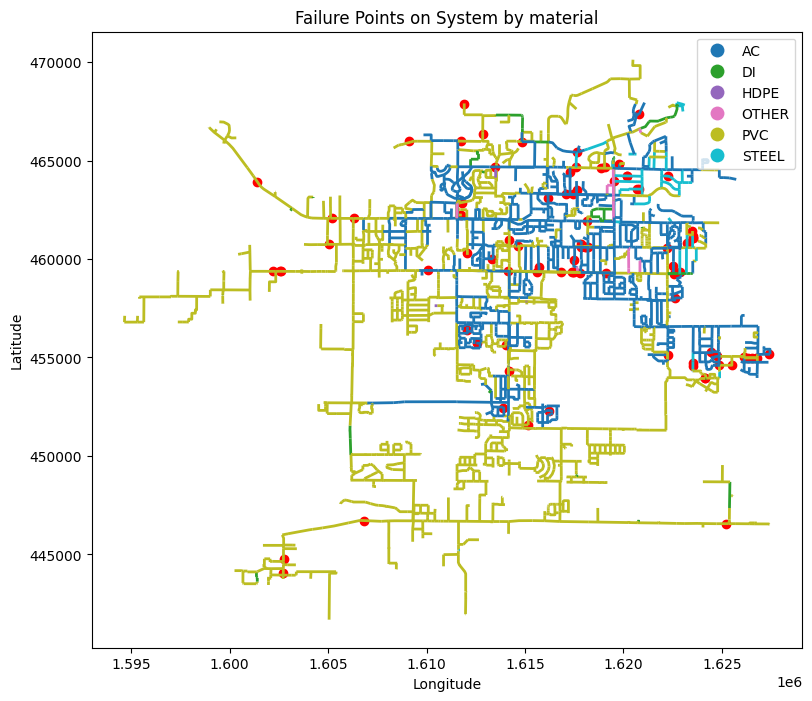

In [ ]:
failures_system_category(final_merged_df,"material")

As well as by pipe_diam

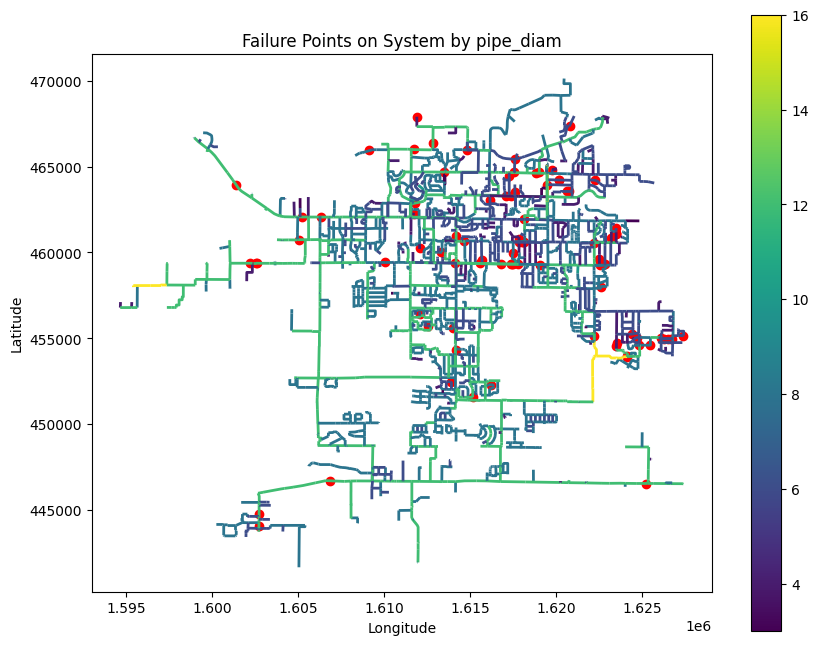

In [ ]:
failures_system_category(final_merged_df,"pipe_diam")

Now that we have a merged dataset, it is interesting to look into some information. We can see that there is a relationship between both, material and failures, with PVC and AC linked to the most failed cases (but also could be as they are the more prolific materials) as well as failures per individual pipe;

In [ ]:
print(final_merged_df["material"][final_merged_df["failed"]==1].value_counts())
print(" ")
print(final_merged_df[final_merged_df["failed"] == 1].groupby("failures")["material"].value_counts())

material
PVC      32
AC       28
STEEL     9
OTHER     1
DI        1
Name: count, dtype: int64
 
failures  material
1.0       PVC         28
          AC          26
          STEEL        5
          DI           1
2.0       PVC          3
          STEEL        3
          AC           1
3.0       PVC          1
          STEEL        1
5.0       AC           1
          OTHER        1
Name: count, dtype: int64


... and pipe diameter, with pipes of a diameter of 6 and 12 reporting the most cases of failures, with pipes of a diameter of 6 and 10 reporting the most failures per individual pipe

In [ ]:
print(final_merged_df["pipe_diam"][final_merged_df["failed"]==1].value_counts())
print(" ")
print(final_merged_df[final_merged_df["failed"] == 1].groupby("failures")["pipe_diam"].value_counts())


pipe_diam
6     26
12    23
8     11
4     10
10     1
Name: count, dtype: int64
 
failures  pipe_diam
1.0       6            22
          12           20
          8            11
          4             7
2.0       12            3
          4             2
          6             2
3.0       4             1
          6             1
5.0       6             1
          10            1
Name: count, dtype: int64


A combination of the two though shows that although PVC at 12 inches and AC at 6 and 8 are the most common material/dimension combos found in failed pipes, the invididual pipes with the most failures are AC 6, PVC 6 and STEEL 4. This can mean that PVC 6 are included as PVC is a prolific material, but STEEL although not as prolific may appear to be a weaker choice

In [ ]:

print(final_merged_df["material_diam"][final_merged_df["failed"]==1].value_counts())
print(" ")
print(final_merged_df[final_merged_df["failed"] == 1].groupby("failures")["material_diam"].value_counts())

material_diam
PVC_12      22
AC_6        17
AC_8         7
STEEL_6      6
PVC_4        4
PVC_8        3
STEEL_4      3
AC_4         3
PVC_6        3
OTHER_10     1
AC_12        1
DI_8         1
Name: count, dtype: int64
 
failures  material_diam
1.0       PVC_12           19
          AC_6             16
          AC_8              7
          PVC_4             4
          STEEL_6           4
          PVC_8             3
          PVC_6             2
          AC_4              2
          AC_12             1
          STEEL_4           1
          DI_8              1
2.0       PVC_12            3
          STEEL_6           2
          STEEL_4           1
          AC_4              1
3.0       STEEL_4           1
          PVC_6             1
5.0       AC_6              1
          OTHER_10          1
Name: count, dtype: int64


**Write a Python function that takes three parameters: the merged dataset, the percentage of pipes to sample, and a random seed for reproducibility. Ensure that the sampling covers all parts of the network.**

Sampling to ensure it covers all parts of the network has to be made in a way that the sample represents pipe characteristics in the original merged dataset. To do this #we will consider taking the stratified sampling technique as the failed pipes are a minority class. This will ensure a more balanced approach. So we will used a proportionate stratified sampling.

In [ ]:
# Stratified sampling

def sampled_data(data,pipes_sampling_percentage,seed):

    """
    Parameters:
    data(dataframe): the dataframe to sample from
    pipes_sampling_percentage(float): the sampling percentage prior chosen for the pipes
    seed(integer) : the seed used to replicate the randomized stratified sampling result


    """

    # We assert the input types
    assert isinstance(pipes_sampling_percentage, float), "The Pipes' sampling percentage must be a float"
    assert isinstance(seed, int), "Seed must be an integer"

    #we will consider the following strata: whether the pipe failed or not, their diameter and material

    new = data.groupby(['failed','pipe_diam','material'], group_keys=False).apply(lambda x: x.sample(frac=pipes_sampling_percentage,random_state=seed))

    return new

In [ ]:
sample = sampled_data(final_merged_df,0.3,100)

display(sample.head())


print(" ")

print("Length of sample: ", len(sample))

,pipe_id,pipe_diam,material,abandoned,abandon_yr,geometry_1,pipe_length,encoded_material,material_diam,material_diam_encoded,event_id,event_year,geometry_2,areas,failures,failed
3046,6287,3,HDPE,0,0,"LINESTRING (1613509.662 464133.985, 1613508.91...",411.274846,2,HDPE_3,11,0,0,None,0.0,0.0,0.0
2882,6086,3,OTHER,0,0,"LINESTRING (1619177.457 463745.716, 1619172.97...",4.482670,3,OTHER_3,15,0,0,None,0.0,0.0,0.0
1749,4146,3,PVC,0,0,"LINESTRING (1613494.372 451912.421, 1613352.21...",142.178934,4,PVC_3,22,0,0,None,0.0,0.0,0.0
935,234,4,AC,0,0,"LINESTRING (1626340.762 454222.475, 1626368.58...",296.842474,0,AC_4,3,0,0,None,0.0,0.0,0.0
1385,317,4,AC,0,0,"LINESTRING (1622260.540 457067.540, 1622386.99...",126.460353,0,AC_4,3,0,0,None,0.0,0.0,0.0


 
Length of sample:  1010


We can now generate two samples using the same seed. Indeed we see that
for sample1 and sample2, we have all pointwise values equal, amounting to 1010 per feature

In [ ]:

sample1 = sampled_data(final_merged_df,0.30,1000)
sample2 = sampled_data(final_merged_df,0.30,1000)

(sample1 == sample2).sum()

pipe_id                  1010
pipe_diam                1010
material                 1010
abandoned                1010
abandon_yr               1010
geometry_1               1010
pipe_length              1010
encoded_material         1010
material_diam            1010
material_diam_encoded    1010
event_id                 1010
event_year               1010
geometry_2                 21
areas                    1010
failures                 1010
failed                   1010
dtype: int64

Which is valid as each sample has a total of 1010 observations


In [ ]:

print("Total observations per sample: ",len(sample1))
print("Equal number of observations?: ",len(sample1) == len(sample2))

Total observations per sample:  1010
Equal number of observations?:  True


As a bonus, I also present a function to create training and test sets on the merged dataset with the 'failed' class as a dependent variable

In [ ]:
def train_test_sample(data, pipes_sampling_percentage, seed):

    # We assert the input types
    assert isinstance(pipes_sampling_percentage, float), "The Pipes' sampling percentage must be a float"
    assert isinstance(seed, int), "Seed must be an integer"

    # Define dependent and independent variables
    X = data[data.columns[:-1]]  # Independent features
    y = data[data.columns[-1]]    # Dependent Variable

    sss = StratifiedShuffleSplit(n_splits=5, test_size=pipes_sampling_percentage, random_state=seed)
    splits = sss.split(X, y)

    # Lists to store the data for each split
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    # Iterate over the splits and collect the data
    for train_index, test_index in splits:
        X_train_list.append(X.iloc[train_index])
        X_test_list.append(X.iloc[test_index])
        y_train_list.append(y.iloc[train_index])
        y_test_list.append(y.iloc[test_index])

    return X_train_list, X_test_list, y_train_list, y_test_list


In [ ]:
X_train, X_test,  y_train, y_test = train_test_sample(final_merged_df,0.3,100)

print(X_train)
print(" ")
print(y_train)

[     pipe_id  pipe_diam material  abandoned  abandon_yr  \
666     1955         12      PVC          0           0   
478     1692          8      PVC          0           0   
255     1362          8       AC          0           0   
826     2195         12      PVC          0           0   
194     1283          8       AC          0           0   
...      ...        ...      ...        ...         ...   
3316     927          8      PVC          0           0   
3034    6272          8      PVC          0           0   
620     1889          8       AC          0           0   
3275     866          6       AC          0           0   
878     2259         12      PVC          0           0   

                                             geometry_1  pipe_length  \
666   LINESTRING (1606365.219 449101.620, 1606353.26...   275.762949   
478   LINESTRING (1619233.671 460573.520, 1619234.65...   118.436425   
255   LINESTRING (1608123.035 461071.547, 1608150.55...   814.805119   
82

**Validate that the distribution of pipes with failures in the sampled dataset is consistent with the original distribution.**

We can start by visualizing the frequency of the pipes with failures

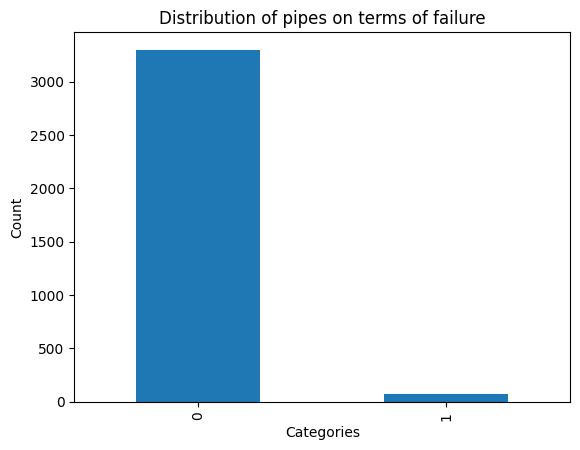

In [ ]:

final_merged_df["failed"].value_counts().plot(kind="bar")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
plt.title("Distribution of pipes on terms of failure")
plt.xlabel("Categories")
plt.ylabel("Count")
plt.show()

We can see that the distribution of the pipes on terms of failure is consistent between the sample and original distribution

In [ ]:
print(sample1["failed"].value_counts()/(len(sample1)))

print(" ")
print(final_merged_df["failed"].value_counts()/len(final_merged_df))

failed
0.0    0.979208
1.0    0.020792
Name: count, dtype: float64
 
failed
0.0    0.978919
1.0    0.021081
Name: count, dtype: float64


We can also validate this for the rest of the features that follow a similar distribution with the original dataset

In [ ]:
sample1.describe()

,pipe_diam,abandoned,abandon_yr,pipe_length,encoded_material,material_diam_encoded,areas,failures,failed
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,8.355446,0.002970,5.975248,282.209461,2.542574,16.155446,0.500990,0.031683,0.020792
std,2.475528,0.054446,109.528100,318.159761,1.929549,9.720300,3.655168,0.261478,0.142758
min,3.000000,0.000000,0.000000,2.007766,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,53.639368,0.000000,5.000000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000,196.629425,4.000000,20.000000,0.000000,0.000000,0.000000
75%,11.500000,0.000000,0.000000,394.378929,4.000000,25.000000,0.000000,0.000000,0.000000
max,16.000000,1.000000,2015.000000,3402.199730,5.000000,28.000000,38.000000,5.000000,1.000000


In [ ]:
final_merged_df.describe()

,pipe_diam,abandoned,abandon_yr,pipe_length,encoded_material,material_diam_encoded,areas,failures,failed
count,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000
mean,8.352435,0.002375,4.780285,279.226077,2.539786,16.141330,0.549287,0.026722,0.021081
std,2.474261,0.048686,97.981380,293.547588,1.929610,9.722596,3.919286,0.213583,0.143675
min,3.000000,0.000000,0.000000,2.006078,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,56.338265,0.000000,5.000000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000,206.335938,4.000000,20.000000,0.000000,0.000000,0.000000
75%,10.000000,0.000000,0.000000,395.827271,4.000000,25.000000,0.000000,0.000000,0.000000
max,16.000000,1.000000,2018.000000,3402.199730,5.000000,29.000000,38.000000,5.000000,1.000000


We can also prove this programmatically using the Kolmogorov-Smirnov test, a non-parametric statistical test used to compare the distributions of two samples

In [ ]:
def similar_distribution_check(sample1, sample2, alpha=0.05):

    """
    Parameters:
    sample1 (DataFrame): First sample.
    sample2 (DataFrame): Second sample.
    alpha (float, optional): Significance level. Default is 0.05.

    Returns:
    bool: True if the null hypothesis cannot be rejected (similar distribution), False otherwise.
    """
    # Choose only numerical columns for sample1 and sample2
    sample1 = sample1[['pipe_diam', 'abandon_yr', 'pipe_length', 'material_diam_encoded']]
    sample2 = sample2[['pipe_diam', 'abandon_yr', 'pipe_length', 'material_diam_encoded']]

    # Convert DataFrames to arrays
    sample1_array = sample1.to_numpy().flatten()
    sample2_array = sample2.to_numpy().flatten()

    # Perform the Kolmogorov-Smirnov test
    stat, p_value = ks_2samp(sample1_array, sample2_array)

    # Compare p-value to significance level
    if p_value > alpha:
        return True  # Cannot reject null hypothesis (similar distribution)
    else:
        return False  # Reject

We can see that indeed the distributions are consistent!

In [ ]:
similar_distribution_check(sample1, final_merged_df, alpha=0.05)

True

# 2. Data cleanup

Consider a water pipe network whose system data we are providing. The data can be active water pipes, abandoned water pipes and historical failures. We want to create a function (or more than one) that will accept as input the given data (two dataframes and the target year value), clean up only the pipes part according to the target year value and will return one dataframe with active and abandoned pipes merged.

The given data:
*   pipes: active pipes (dataframe)
*   abd_pipes: abandoned pipes (dataframe)
*   target_year: target year (variable)

Dataframes include the following columns:
*   pipe_id: the unique id of each pipe (this field cannot have duplicates or missing values)
*   install_yr: the installation year of the pipe
*   abandon_yr: the abandon year of the pipe
*   abandoned: 0 = not abandoned pipe, 1 = abandoned pipe

You need to implement any checks you think nessecary according to the instructions. Based on the target year you need to assign correctly if a pipe was abandoned or active on that year and after that take care of the column values. In the end, merge these 2 dataframes in one. Feel free to find your own solutions.


An example:

**pipes**

pipe_id 1, install_yr 2020, abandon_yr 0, abandoned 0<br/><br/>

**abd_pipes**

pipe_id 1, install_yr 2008, abandon_yr 2022, abandoned 1<br/><br/>

**target_year** = 2021<br/><br/>

In this example, we need to assign for 2021 the active and abandoned pipes. So, we need to convert the abandoned pipe with id 1 as active as this pipe was abandoned in 2022.

In [ ]:
import pandas as pd
target_year = 2021

pip = pd.DataFrame(
    {'pipe_id': [1, '2', '3', '4', '5'],
     'install_yr': ['1994', '2002', '2019', '2021', '1986'],
     'abandoned': [0, 0, 0, 0, 1],
     'abandon_yr': [0, 0, 0, 0, '2003']})

abd_pipes = pd.DataFrame(
    {'pipe_id': ['1', '2', 3.0, '4', '5'],
     'install_yr': [1994, '2002', '2019', '2021', '1986'],
     'abandoned': ['1', 1, 1, 0, 1],
     'abandon_yr': [2022, 2022, 2019, 0, 2002]})

In [ ]:
    display(pip)
    display(abd_pipes)

,pipe_id,install_yr,abandoned,abandon_yr
0,1,1994,0,0
1,2,2002,0,0
2,3,2019,0,0
3,4,2021,0,0
4,5,1986,1,2003


,pipe_id,install_yr,abandoned,abandon_yr
0,1,1994,1,2022
1,2,2002,1,2022
2,3.0,2019,1,2019
3,4,2021,0,0
4,5,1986,1,2002


We will create two helper functions in addition to the function in question. It is always useful to be able to perform intermediary analyses to newly acquired dataframes for further insights to enhance expert knowledge systems' dimensions. Having intermediary functions also brings several advantages.

Firstly, it enhances modularity and readability by breaking down the larger function into smaller, more focused tasks making the code easier to understand and navigate. Secondly, it promotes code reusability as these intermediate functions can be utilized in multiple contexts, reducing duplication and enhancing maintainability. Thirdly, it facilitates testing by allowing for isolated testing of each function, ensuring that each component behaves as expected. Finally, debugging becomes more straightforward as errors can be pinpointed to specific functions or subtasks.

The first function will handle pre-processing of the dataframes. We have to ensure that all values are numerical and also that the active pipes dataframe only has active pipes, whereas the abandoned pipes dataframe only has abandoned pipes. It will also treat pipe_ids to ensure uniqueness and abandoned values corresponding to the target year in the abandoned dataframe.

This function is called "preprocess" takes three input values:

i) data: the input dataframe

ii) abandoned: a dummy indicating 0 for active and 1 for abandoned

iii) target_year: the target year for the assignment



In [ ]:

def preprocess_dataframe(data,abandoned, target_year):
    """
    Parameters:

    data(dataframe): the input dataframe
    abandoned(int): a dummy variable with 1 for abandoned and 0 for active
    target_year(int): the target year in question

    """

    # Assert input values correspond to the correct format
    assert isinstance(data, pd.DataFrame), "Data must be in dataframe format"
    assert isinstance(abandoned, int), "Abandoned must be numerical"
    assert isinstance(target_year, int), "Target Year must be numerical"

    # The function first ensures all values are numeric
    data = data.apply(pd.to_numeric, errors="coerce")

    # The input dataframe type(active or abandoned) only include pipes of their respective types,
    # determined by the numeric value in the abandoned variable: 0 for active and 1 for abandoned.
    #data = data[data['abandoned'] == abandoned].copy()

    if abandoned==1:

      # In case the dataframe refers to abandoned columns, we need first regulate the
      # pipe_id. We will convert the 'pipe_id' column to string type and add prefix 'abd'
      # to distinguish the abandoned version of the same pipe_id
        data["pipe_id"] = "abd" + data["pipe_id"].astype(str).str[:-2]

      # We considered the misslabeled ones if any
        misslabeled = data[data['abandoned'] == 0]

        original_data = data.copy()

      # And filter for the correctly labelled ones
        data = data[data['abandoned'] == abandoned].copy()


      # We will then determine as abandoned all pipes whose abandonment year is before or
      # equal to the target year, and address as active (abandoned=0) all others
        data.loc[data["abandon_yr"] <= target_year, "abandoned"] = 1
        data.loc[data["abandon_yr"] > target_year, "abandoned"] = 0

        abd_to_act = []

        for index, row in data.iterrows():

            pipe_id = row['pipe_id']

            # Check if the pipe changed from abandoned to active
            if row['abandoned'] == 0 and (original_data.loc[original_data['pipe_id'] == pipe_id, 'abandoned'] == 1).any():
                abd_to_act.append(row['pipe_id'])

        print("The following abandoned pipes became active:", abd_to_act)

        if len(misslabeled)>0:
            print("The following abandoned pipes were dropped as they were misslabeled as active:", misslabeled['pipe_id'].tolist())

    else:
        misslabeled = data[data['abandoned'] == 1]
        data = data[data['abandoned'] == abandoned]

        if len(misslabeled)>0:
            print("The following active pipes were dropped as they were misslabeled as abandoned:", misslabeled['pipe_id'].tolist())

    return data

The second function shows an early version of the merged dataframe and is called "premerged", making an early concatenation of the cleaned active and abandoned dataframes.

It takes three inputs:
i) pipes: the active pipes dataframe

ii) abd_pipes: the abandoned pipes dataframe

iii) target_year: the target year in question

In [ ]:

def premerged_dataframes(pipes, abd_pipes, target_year):

    # Clean active and abandoned pipes,by ensuring all values are numeric, dataframes only include their respective types
    # and correctly handle abandoned and pipe_id values for the abandoned dataframe
    p, a = [preprocess_dataframe(df, pipe_type, target_year) for df, pipe_type in [(pipes, 0), (abd_pipes, 1)]]

    #Concantenate the two dataframes
    merged_pipes = pd.concat([p, a])

    return merged_pipes

We can take a look at each helper function per dataframe and then the overall premerge

In [ ]:

pipes_clean = preprocess_dataframe(pip,0, target_year)
display(pipes_clean)

The following active pipes were dropped as they were misslabeled as abandoned: [5]


,pipe_id,install_yr,abandoned,abandon_yr
0,1,1994,0,0
1,2,2002,0,0
2,3,2019,0,0
3,4,2021,0,0


In [ ]:

abd_pipes_clean = preprocess_dataframe(abd_pipes,1, target_year)
display(abd_pipes_clean)

The following abandoned pipes became active: ['abd1', 'abd2']
The following abandoned pipes were dropped as they were misslabeled as active: ['abd4']


,pipe_id,install_yr,abandoned,abandon_yr
0,abd1,1994,0,2022
1,abd2,2002,0,2022
2,abd3,2019,1,2019
4,abd5,1986,1,2002


In [ ]:

premerged_pipes_abd_pipes = premerged_dataframes(pip, abd_pipes, target_year)
display(premerged_pipes_abd_pipes)

The following active pipes were dropped as they were misslabeled as abandoned: [5]
The following abandoned pipes became active: ['abd1', 'abd2']
The following abandoned pipes were dropped as they were misslabeled as active: ['abd4']


,pipe_id,install_yr,abandoned,abandon_yr
0,1,1994,0,0
1,2,2002,0,0
2,3,2019,0,0
3,4,2021,0,0
0,abd1,1994,0,2022
1,abd2,2002,0,2022
2,abd3,2019,1,2019
4,abd5,1986,1,2002


We can also test the introduced assertions for incorrect input values introduced by the user

In [ ]:
try:
    premerged_dataframes(pip, abd_pipes, "2021")
except AssertionError as e:
    print("AssertionError:", e)

AssertionError: Target Year must be numerical


In [ ]:
try:
    premerged_dataframes(pip, 'abd_pipes', target_year)
except AssertionError as e:
    print("AssertionError:", e)

The following active pipes were dropped as they were misslabeled as abandoned: [5]
AssertionError: Data must be in dataframe format


Finally, the final function is called "complete_merged_dataframes", takes the same inputs as "premerge" and performs the overall operation of preprocessing, premerging and offering a clean merged version of the active and abandoned pipes according to the input target year to facilitate historical analysis of failures in active pipes and their abandoned equivalents if any:

In [ ]:

def complete_merged_dataframes(pipes, abd_pipes, target_year):

    #We first preprocess the data and premerge
    cleaned_df = premerged_dataframes(pipes, abd_pipes, target_year)

    #Then we reset the index
    cleaned_df.reset_index(inplace=True, drop=True)

    return cleaned_df

In [ ]:
final_pipes_abd_pipes = complete_merged_dataframes(pip, abd_pipes, target_year)
display(final_pipes_abd_pipes)

The following active pipes were dropped as they were misslabeled as abandoned: [5]
The following abandoned pipes became active: ['abd1', 'abd2']
The following abandoned pipes were dropped as they were misslabeled as active: ['abd4']


,pipe_id,install_yr,abandoned,abandon_yr
0,1,1994,0,0
1,2,2002,0,0
2,3,2019,0,0
3,4,2021,0,0
4,abd1,1994,0,2022
5,abd2,2002,0,2022
6,abd3,2019,1,2019
7,abd5,1986,1,2002


Code rules

1. Duplication is evil

    Avoid writing duplicate code as much as possible. Even 1 line of duplicate code (if it’s fairly complex) is bad. Sooner or later you'll need to change that code, and if it’s duplicated in multiple places, it is very easy to introduce a bug. Instead of duplicating code, write functions.

2. Be consistent with formatting

    Use the same spacing, same indentation, and same naming conventions everywhere. Do not write code likeThis and then like_that, or this=that, and then this = that.

3. Do not surprise the users of your functions

    A function should do exactly what its name and parameters suggest, nothing more, nothing less.

4. Use good names for your functions and parameters that make sense

    The names should make it very clear what the function does. The parameters should also be clear, pay attention even to the order of the parameters. When someone is reading some code that uses your function, it should be clear, e.g.,
   <br/>delete_duplicate_pipes(pipes_df)  # it's clear what this does
   <br/> duplicate_pipes(df)  # what exactly does this do

5. No hardcoded values, unless it is globally obvious

    You can write that circle_diameter = 2 * PI_VALUE * radius since 2 is pretty obvious but in probability = 0.0432 * x_variable, 0.0432 should be a constant with a meaningful name.

6. Do not trust the users of your functions

    Always assume that sooner or later they’ll pass something wrong in the parameters, so always check the parameters (use assertions).

7. Make sure you have good documentation for every function we are writing

    def calculate_summary(first_int, second_int):
    """What exactly the function does.

    Keyword arguments:
    first_int -- what is the parameter first_int
    second_int -- what is the parameter second_int
    :return: what is the return parameter
    """
    summary_int = first_int + second_int
    return summary_int

8. The order you are passing a parameter in a function is important, e.g.

    ❌ def just_a_test(parameter, data_folder, df):
    ✅ def just_a_test(data_folder, df, parameter):
    Read from <data_folder> → create a dataframe <df> → use <parameter>

9. Quotes usage

    - Single quotes:
      - List values
      - Dictionary keys
    - Double quotes:
      - All the rest

Good luck!